# WAE-GAN model

In [1]:
from model.exp1.train_wae_gan import WAE_GAN_MNIST as MODEL1
from model.exp2.train_wae_gan import WAE_GAN_MNIST as MODEL2

In [6]:
import os, sys, time, logging, configparser
# sys.path.append('/'.join(os.getcwd().split('/')))
import warnings
warnings.filterwarnings("ignore")
# os.environ['CUDA_VISIBLE_DEVICES']='7'
from XAE.dataset import MNIST
from XAE.util import init_params, calculate_sharpness, calculate_sharpness_generator, sigmoid
from XAE.sampler import gaus, multinomial
from XAE.logging_daily import logging_daily
import XAE.fid as fid

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

logger = logging_daily('./config/log_info.yaml')
log = logger.get_logging()
log.setLevel(logging.INFO)

cfg1 = configparser.ConfigParser()
cfg1.read('./config/train_config_wae_gan1.cfg')

cfg2 = configparser.ConfigParser()
cfg2.read('./config/train_config_wae_gan2.cfg')

test_data = MNIST(cfg1['path_info']['data_home'], train = False, label = True)
test_data2 = MNIST(cfg1['path_info']['data_home'], train = False, label = False, output_channels = 3)

## Load WAE-GAN model

In [5]:
model1 = MODEL1(cfg1, log, device=device, verbose=0)
model1.load(cfg1['path_info']['save_path'])

In [6]:
model2 = MODEL2(cfg2, log, device=device, verbose=0)
model2.load(cfg2['path_info']['save_path'])

### Reconstruction from test set

In [16]:
test_generator = torch.utils.data.DataLoader(test_data, 16, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
test_sample_image, test_sample_label = next(iter(test_generator))
recon_sample = model1(test_sample_image.to(device)).to('cpu').detach().numpy()

In [8]:
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)

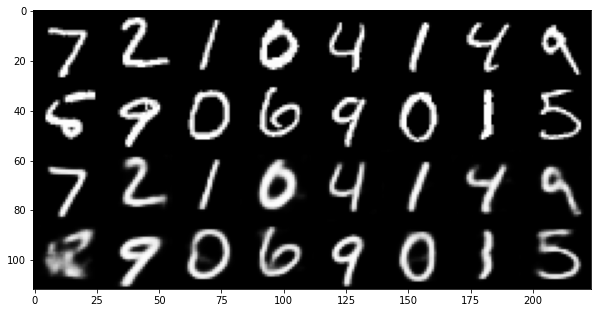

In [9]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model1

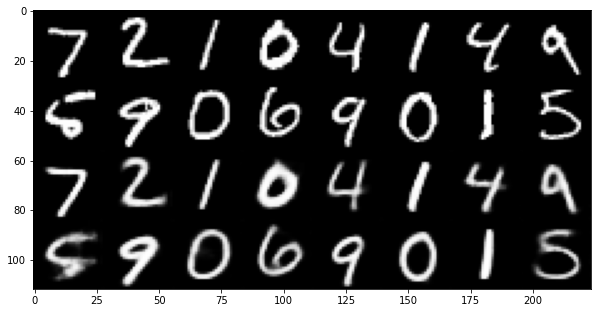

In [10]:
recon_sample = model2(test_sample_image.to(device)).to('cpu').detach().numpy()
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model2

### Generation from prior distribution

In [11]:
z = gaus(60, 8)
Z = z.to(device)

In [12]:
gen_sample1 = model1.decode(Z).to('cpu').detach().numpy() # generated samples in numpy
gen_sample2 = model2.decode(Z).to('cpu').detach().numpy() # generated samples in numpy

gz1, gz2 = [], []
for i in range(6):
    gz1.append(np.concatenate([gen_sample1[10*i + j,0,:,:] for j in range(10)], axis = 1))
    gz2.append(np.concatenate([gen_sample2[10*i + j,0,:,:] for j in range(10)], axis = 1))
generation_result1 = np.concatenate(gz1, axis = 0) # concatenate matrix for plt
generation_result2 = np.concatenate(gz2, axis = 0) # concatenate matrix for plt

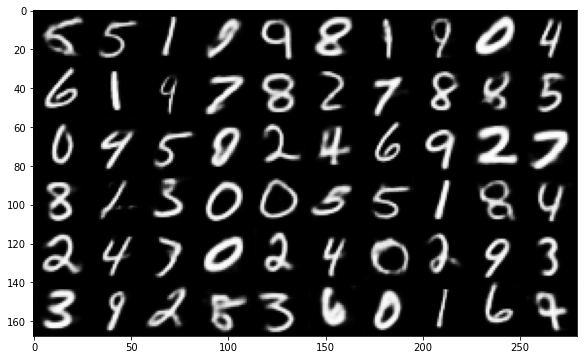

In [13]:
plt.figure(figsize = (10.0, 6.0))
plt.imshow(generation_result1, cmap='gray', vmin=-1, vmax=1)
plt.show()

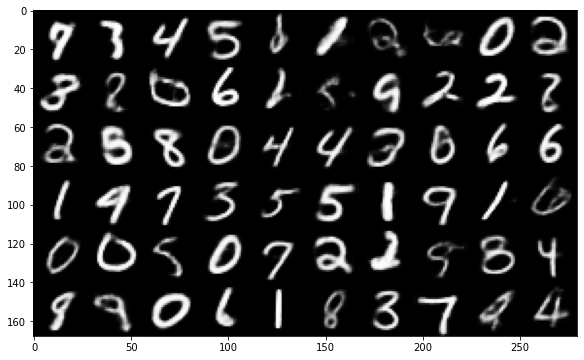

In [14]:
plt.figure(figsize = (10.0, 6.0))
plt.imshow(generation_result2, cmap='gray', vmin=-1, vmax=1)
plt.show()

### Sharpness and FID

In [16]:
z_sampler = lambda x: gaus(x, 8).to(device)

In [17]:
ss = calculate_sharpness(test_data2, device = device)
ss.mean()

0.7309414733842016

In [22]:
sharp1 = calculate_sharpness_generator(model1.dec, z_sampler, batch_size=100, repeat=10, device=device)
np.mean(sharp1)

0.3482893093973398

In [23]:
sharp2 = calculate_sharpness_generator(model2.dec, z_sampler, batch_size=100, repeat=10, device=device)
np.mean(sharp2)

0.3629975921586156

In [24]:
fid_model = fid.InceptionV3().to(device)

In [25]:
m1, s1 = fid.calculate_activation_statistics(test_data2, fid_model, batch_size=100, dims=2048, device=device)

100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


In [26]:
act1 = fid.get_activations_generator(model1.dec, z_sampler, fid_model, batch_size=100, repeat=10, dims=2048, device=device)
m2 = np.mean(act1, axis=0)
s2 = np.cov(act1, rowvar=False)

In [27]:
fid.calculate_frechet_distance(m1, s1, m2, s2) # fid of model1

29.113733678813958

In [28]:
act2 = fid.get_activations_generator(model2.dec, z_sampler, fid_model, batch_size=100, repeat=10, dims=2048, device=device)
m3 = np.mean(act2, axis=0)
s3 = np.cov(act2, rowvar=False)

In [29]:
fid.calculate_frechet_distance(m1, s1, m3, s3) # fid of model2

27.447171886243552

# WAE-MMD model

In [9]:
from model.exp1.train_wae_mmd import WAE_MMD_MNIST as MODEL1
from model.exp2.train_wae_mmd import WAE_MMD_MNIST as MODEL2

In [10]:
cfg1 = configparser.ConfigParser()
cfg1.read('./config/train_config_wae_mmd1.cfg')

cfg2 = configparser.ConfigParser()
cfg2.read('./config/train_config_wae_mmd2.cfg')

['./config/train_config_wae_mmd2.cfg']

## Load WAE-GAN model

In [11]:
model1 = MODEL1(cfg1, log, device=device, verbose=0)
model1.load(cfg1['path_info']['save_path'])

In [12]:
model2 = MODEL2(cfg2, log, device=device, verbose=0)
model2.load(cfg2['path_info']['save_path'])

### Reconstruction from test set

In [15]:
recon_sample = model1(test_sample_image.to(device)).to('cpu').detach().numpy()
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)

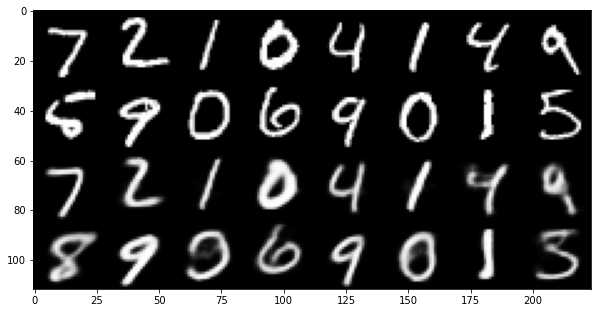

In [16]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model1

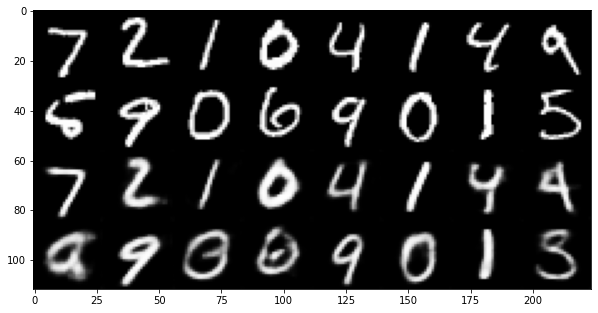

In [17]:
recon_sample = model2(test_sample_image.to(device)).to('cpu').detach().numpy()
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model2

### Generation from prior distribution

In [18]:
z = gaus(60, 8)
Z = z.to(device)

In [19]:
gen_sample1 = model1.decode(Z).to('cpu').detach().numpy() # generated samples in numpy
gen_sample2 = model2.decode(Z).to('cpu').detach().numpy() # generated samples in numpy

gz1, gz2 = [], []
for i in range(6):
    gz1.append(np.concatenate([gen_sample1[10*i + j,0,:,:] for j in range(10)], axis = 1))
    gz2.append(np.concatenate([gen_sample2[10*i + j,0,:,:] for j in range(10)], axis = 1))
generation_result1 = np.concatenate(gz1, axis = 0) # concatenate matrix for plt
generation_result2 = np.concatenate(gz2, axis = 0) # concatenate matrix for plt

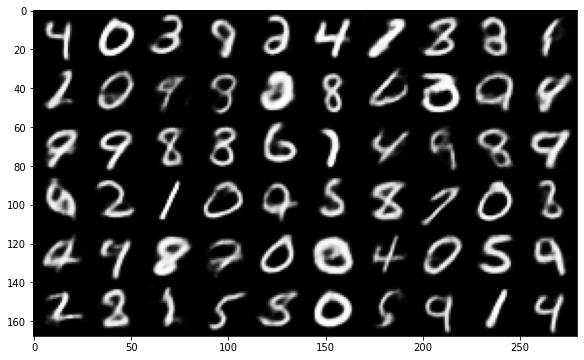

In [20]:
plt.figure(figsize = (10.0, 6.0))
plt.imshow(generation_result1, cmap='gray', vmin=-1, vmax=1)
plt.show()

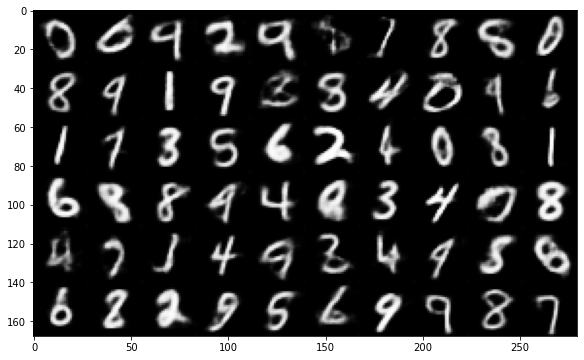

In [21]:
plt.figure(figsize = (10.0, 6.0))
plt.imshow(generation_result2, cmap='gray', vmin=-1, vmax=1)
plt.show()

### Sharpness and FID

In [22]:
z_sampler = lambda x: gaus(x, 8).to(device)

In [23]:
ss = calculate_sharpness(test_data2, device = device)
ss.mean()

0.7309414733842016

In [24]:
sharp1 = calculate_sharpness_generator(model1.dec, z_sampler, batch_size=100, repeat=10, device=device)
np.mean(sharp1)

0.25608409981802105

In [25]:
sharp2 = calculate_sharpness_generator(model2.dec, z_sampler, batch_size=100, repeat=10, device=device)
np.mean(sharp2)

0.2512015810981393

In [26]:
fid_model = fid.InceptionV3().to(device)

In [27]:
m1, s1 = fid.calculate_activation_statistics(test_data2, fid_model, batch_size=100, dims=2048, device=device)

100%|██████████| 100/100 [00:34<00:00,  2.90it/s]


In [28]:
act1 = fid.get_activations_generator(model1.dec, z_sampler, fid_model, batch_size=100, repeat=10, dims=2048, device=device)
m2 = np.mean(act1, axis=0)
s2 = np.cov(act1, rowvar=False)

In [29]:
fid.calculate_frechet_distance(m1, s1, m2, s2) # fid of model1

33.78594025103459

In [30]:
act2 = fid.get_activations_generator(model2.dec, z_sampler, fid_model, batch_size=100, repeat=10, dims=2048, device=device)
m3 = np.mean(act2, axis=0)
s3 = np.cov(act2, rowvar=False)

In [31]:
fid.calculate_frechet_distance(m1, s1, m3, s3) # fid of model2

37.89473127207333

# VAE model

In [12]:
from model.exp1.train_vae import VAE_MNIST as MODEL1
from model.exp2.train_vae import VAE_MNIST as MODEL2

In [13]:
cfg1 = configparser.ConfigParser()
cfg1.read('./config/train_config_vae1.cfg')

cfg2 = configparser.ConfigParser()
cfg2.read('./config/train_config_vae2.cfg')

['./config/train_config_vae2.cfg']

## Load VAE model

In [14]:
model1 = MODEL1(cfg1, log, device=device, verbose=0)
model1.load(cfg1['path_info']['save_path'])

In [15]:
model2 = MODEL2(cfg2, log, device=device, verbose=0)
model2.load(cfg2['path_info']['save_path'])

### Reconstruction from test set

In [52]:
recon_sample = sigmoid(model1(test_sample_image.to(device)).to('cpu').detach().numpy()) * 2 - 1
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)

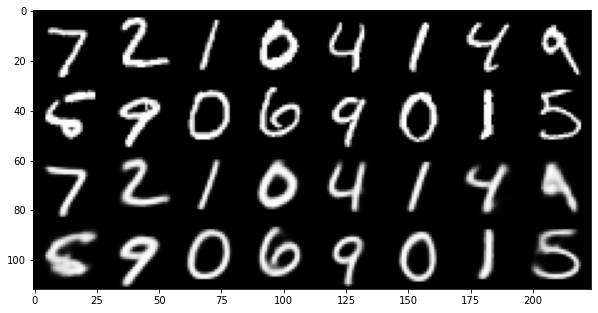

In [53]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model1

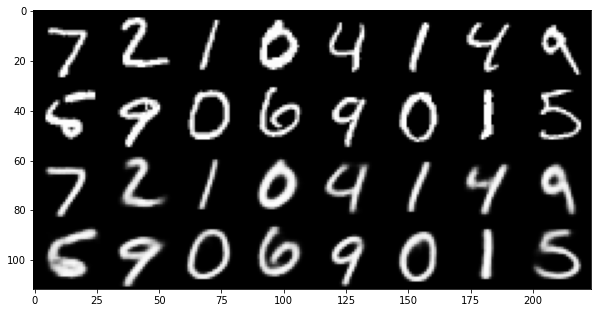

In [51]:
recon_sample = sigmoid(model2(test_sample_image.to(device)).to('cpu').detach().numpy()) * 2 - 1
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model2

### Generation from prior distribution

In [34]:
z = gaus(60, 8)
Z = z.to(device)

In [37]:
gen_sample1 = sigmoid(model1.decode(Z).to('cpu').detach().numpy()) # generated samples in numpy
gen_sample2 = sigmoid(model2.decode(Z).to('cpu').detach().numpy()) # generated samples in numpy

gz1, gz2 = [], []
for i in range(6):
    gz1.append(np.concatenate([gen_sample1[10*i + j,0,:,:] for j in range(10)], axis = 1))
    gz2.append(np.concatenate([gen_sample2[10*i + j,0,:,:] for j in range(10)], axis = 1))
generation_result1 = np.concatenate(gz1, axis = 0) # concatenate matrix for plt
generation_result2 = np.concatenate(gz2, axis = 0) # concatenate matrix for plt

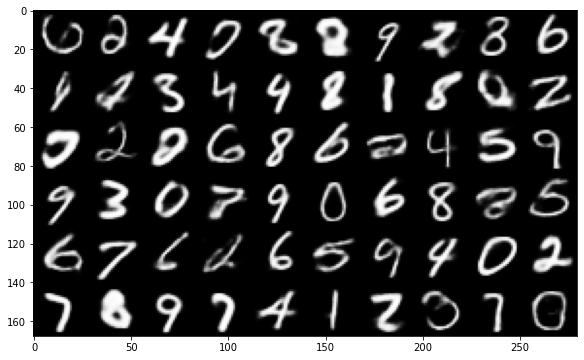

In [38]:
plt.figure(figsize = (10.0, 6.0))
plt.imshow(generation_result1, cmap='gray', vmin=0, vmax=1)
plt.show()

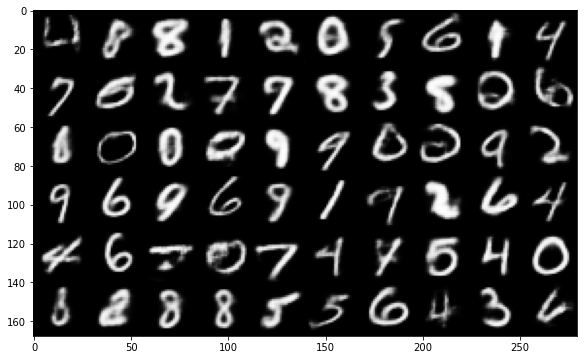

In [40]:
plt.figure(figsize = (10.0, 6.0))
plt.imshow(generation_result2, cmap='gray', vmin=0, vmax=1)
plt.show()

### Sharpness and FID

In [41]:
z_sampler = lambda x: gaus(x, 8).to(device)

In [42]:
ss = calculate_sharpness(test_data2, device = device)
ss.mean()

0.7309414733842016

In [64]:
sig_dec1 = lambda x: torch.sigmoid(model1.dec(x)) * 2 - 1
sharp1 = calculate_sharpness_generator(sig_dec1, z_sampler, batch_size=100, repeat=10, device=device)
np.mean(sharp1)

0.3142633776664734

In [58]:
sig_dec2 = lambda x: torch.sigmoid(model2.dec(x)) * 2 - 1
sharp2 = calculate_sharpness_generator(sig_dec2, z_sampler, batch_size=100, repeat=10, device=device)
np.mean(sharp2)

0.24671134050935506

In [59]:
fid_model = fid.InceptionV3().to(device)

In [60]:
m1, s1 = fid.calculate_activation_statistics(test_data2, fid_model, batch_size=100, dims=2048, device=device)

100%|██████████| 100/100 [00:35<00:00,  2.84it/s]


In [65]:
act1 = fid.get_activations_generator(sig_dec1, z_sampler, fid_model, batch_size=100, repeat=10, dims=2048, device=device)
m2 = np.mean(act1, axis=0)
s2 = np.cov(act1, rowvar=False)

In [66]:
fid.calculate_frechet_distance(m1, s1, m2, s2) # fid of model1

28.429190634664394

In [67]:
act2 = fid.get_activations_generator(sig_dec2, z_sampler, fid_model, batch_size=100, repeat=10, dims=2048, device=device)
m3 = np.mean(act2, axis=0)
s3 = np.cov(act2, rowvar=False)

In [68]:
fid.calculate_frechet_distance(m1, s1, m3, s3) # fid of model2

33.677065573612026

# CWAE-GAN model

In [30]:
from model.exp1.train_cwae_gan import CWAE_GAN_MNIST as MODEL1
from model.exp2.train_cwae_gan import CWAE_GAN_MNIST as MODEL2

In [31]:
cfg1 = configparser.ConfigParser()
cfg1.read('./config/train_config_cwae_gan1.cfg')

cfg2 = configparser.ConfigParser()
cfg2.read('./config/train_config_cwae_gan2.cfg')

['./config/train_config_cwae_gan2.cfg']

## Load CWAE-GAN model

In [32]:
model1 = MODEL1(cfg1, log, device=device, verbose=0)
model1.load(cfg1['path_info']['save_path'])

In [33]:
model2 = MODEL2(cfg2, log, device=device, verbose=0)
model2.load(cfg2['path_info']['save_path'])

### Reconstruction from test set

In [35]:
recon_sample = model1(test_sample_image.to(device), test_sample_label.to(device)).to('cpu').detach().numpy()
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)

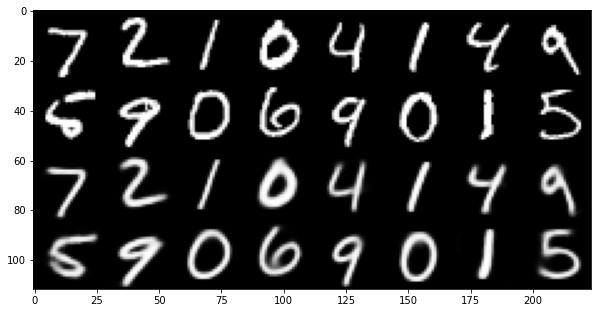

In [36]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model1

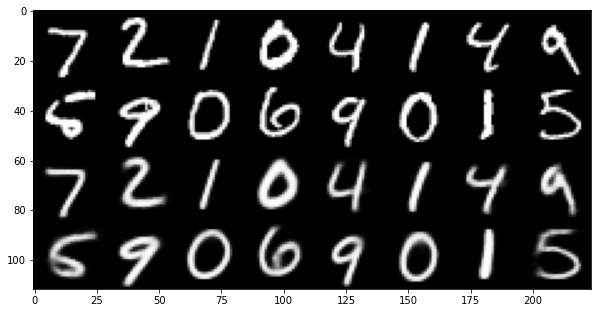

In [37]:
recon_sample = model2(test_sample_image.to(device), test_sample_label.to(device)).to('cpu').detach().numpy()
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model2

### Generation from prior distribution

In [38]:
test_z = []
test_label = []
z = gaus(6, 6)
print(z.shape)
for i in range(10):
    test_z.append(z)
    test_label.append(test_data.code[i].repeat(6,1))
    
test_z = torch.cat(test_z, dim = 0)
test_label = torch.cat(test_label, dim = 0)

Z = torch.cat([test_z, test_label], dim = 1).to(device)
Z.shape

torch.Size([6, 6])


torch.Size([60, 16])

In [39]:
gen_sample1 = model1.decode(Z).to('cpu').detach().numpy() # generated samples in numpy
gen_sample2 = model2.decode(Z).to('cpu').detach().numpy() # generated samples in numpy

gz = []
for i in range(10):
    tmp = [gen_sample1[6*i + j,0,:,:] for j in range(6)] + [gen_sample2[6*i + j,0,:,:] for j in range(6)]
    gz.append(np.concatenate(tmp, axis = 1))
generation_result = np.concatenate(gz, axis = 0) # concatenate matrix for plt

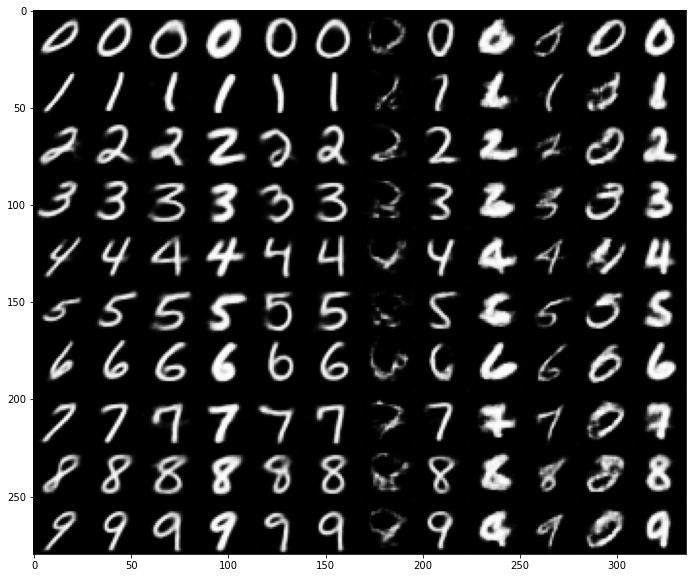

In [41]:
plt.figure(figsize = (12, 10))
plt.imshow(generation_result, cmap='gray', vmin=-1, vmax=1)
plt.show()

### Sharpness and FID

In [45]:
z_sampler = lambda x : torch.cat([gaus(x, 6), multinomial(x, 10)], dim = 1).to(device)

In [47]:
sharp1 = calculate_sharpness_generator(model1.dec, z_sampler, batch_size=100, repeat=10, device=device)
np.mean(sharp1)

0.3189341322183609

In [48]:
sharp2 = calculate_sharpness_generator(model2.dec, z_sampler, batch_size=100, repeat=10, device=device)
np.mean(sharp2)

0.2721570322737098

In [55]:
fid_model = fid.InceptionV3().to(device)

In [56]:
m1, s1 = fid.calculate_activation_statistics(test_data2, fid_model, batch_size=100, dims=2048, device=device)

100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


In [51]:
act1 = fid.get_activations_generator(model1.dec, z_sampler, fid_model, batch_size=100, repeat=10, dims=2048, device=device)
m2 = np.mean(act1, axis=0)
s2 = np.cov(act1, rowvar=False)

In [52]:
fid.calculate_frechet_distance(m1, s1, m2, s2) # fid of model1

38.81018243710088

In [57]:
act2 = fid.get_activations_generator(model2.dec, z_sampler, fid_model, batch_size=100, repeat=10, dims=2048, device=device)
m3 = np.mean(act2, axis=0)
s3 = np.cov(act2, rowvar=False)

In [58]:
fid.calculate_frechet_distance(m1, s1, m3, s3) # fid of model2

36.96431680671799

# CWAE-MMD model

In [69]:
from model.exp1.train_cwae_mmd import CWAE_MMD_MNIST as MODEL1
from model.exp2.train_cwae_mmd import CWAE_MMD_MNIST as MODEL2

In [70]:
cfg1 = configparser.ConfigParser()
cfg1.read('./config/train_config_cwae_mmd1.cfg')

cfg2 = configparser.ConfigParser()
cfg2.read('./config/train_config_cwae_mmd2.cfg')

['./config/train_config_cwae_mmd2.cfg']

## Load CWAE-GAN model

In [71]:
model1 = MODEL1(cfg1, log, device=device, verbose=0)
model1.load(cfg1['path_info']['save_path'])

In [72]:
model2 = MODEL2(cfg2, log, device=device, verbose=0)
model2.load(cfg2['path_info']['save_path'])

### Reconstruction from test set

In [73]:
recon_sample = model1(test_sample_image.to(device), test_sample_label.to(device)).to('cpu').detach().numpy()
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)

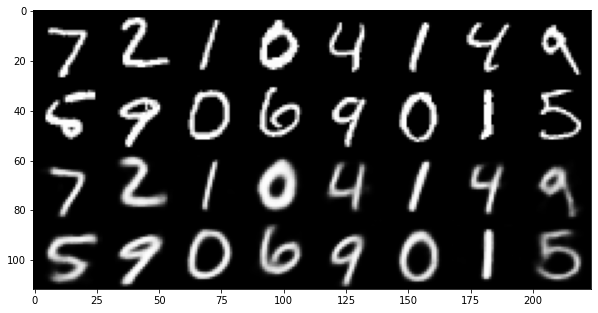

In [74]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model1

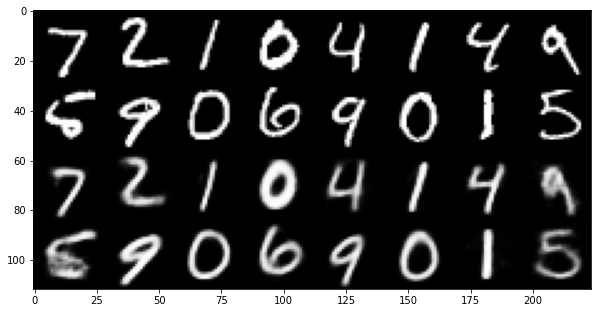

In [75]:
recon_sample = model2(test_sample_image.to(device), test_sample_label.to(device)).to('cpu').detach().numpy()
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model2

### Generation from prior distribution

In [76]:
test_z = []
test_label = []
z = gaus(6, 6)
print(z.shape)
for i in range(10):
    test_z.append(z)
    test_label.append(test_data.code[i].repeat(6,1))
    
test_z = torch.cat(test_z, dim = 0)
test_label = torch.cat(test_label, dim = 0)

Z = torch.cat([test_z, test_label], dim = 1).to(device)
Z.shape

torch.Size([6, 6])


torch.Size([60, 16])

In [77]:
gen_sample1 = model1.decode(Z).to('cpu').detach().numpy() # generated samples in numpy
gen_sample2 = model2.decode(Z).to('cpu').detach().numpy() # generated samples in numpy

gz = []
for i in range(10):
    tmp = [gen_sample1[6*i + j,0,:,:] for j in range(6)] + [gen_sample2[6*i + j,0,:,:] for j in range(6)]
    gz.append(np.concatenate(tmp, axis = 1))
generation_result = np.concatenate(gz, axis = 0) # concatenate matrix for plt

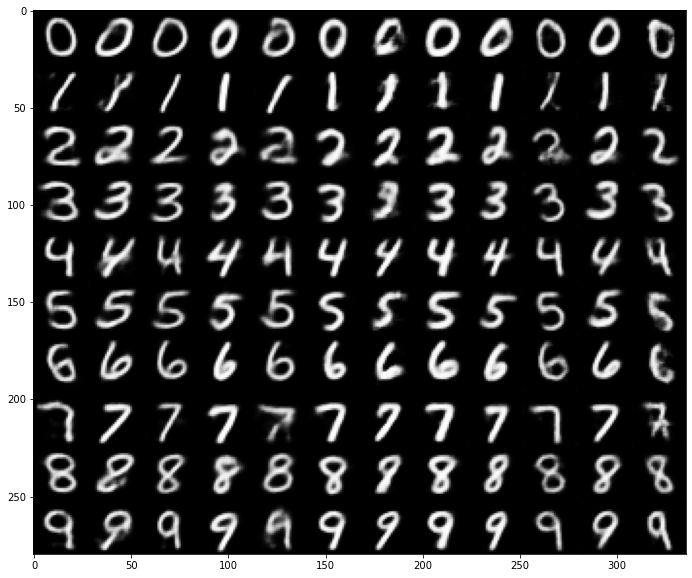

In [78]:
plt.figure(figsize = (12, 10))
plt.imshow(generation_result, cmap='gray', vmin=-1, vmax=1)
plt.show()

### Sharpness and FID

In [79]:
z_sampler = lambda x : torch.cat([gaus(x, 6), multinomial(x, 10)], dim = 1).to(device)

In [80]:
sharp1 = calculate_sharpness_generator(model1.dec, z_sampler, batch_size=100, repeat=10, device=device)
np.mean(sharp1)

0.24102061519026757

In [81]:
sharp2 = calculate_sharpness_generator(model2.dec, z_sampler, batch_size=100, repeat=10, device=device)
np.mean(sharp2)

0.2403922988139093

In [82]:
fid_model = fid.InceptionV3().to(device)

In [83]:
m1, s1 = fid.calculate_activation_statistics(test_data2, fid_model, batch_size=100, dims=2048, device=device)

100%|██████████| 100/100 [00:34<00:00,  2.94it/s]


In [84]:
act1 = fid.get_activations_generator(model1.dec, z_sampler, fid_model, batch_size=100, repeat=10, dims=2048, device=device)
m2 = np.mean(act1, axis=0)
s2 = np.cov(act1, rowvar=False)

In [85]:
fid.calculate_frechet_distance(m1, s1, m2, s2) # fid of model1

44.650169630215146

In [86]:
act2 = fid.get_activations_generator(model2.dec, z_sampler, fid_model, batch_size=100, repeat=10, dims=2048, device=device)
m3 = np.mean(act2, axis=0)
s3 = np.cov(act2, rowvar=False)

In [87]:
fid.calculate_frechet_distance(m1, s1, m3, s3) # fid of model2

43.25525155589895

# CVAE model

In [88]:
from model.exp1.train_cvae import CVAE_MNIST as MODEL1
from model.exp2.train_cvae import CVAE_MNIST as MODEL2

In [89]:
cfg1 = configparser.ConfigParser()
cfg1.read('./config/train_config_cvae1.cfg')

cfg2 = configparser.ConfigParser()
cfg2.read('./config/train_config_cvae2.cfg')

['./config/train_config_cvae2.cfg']

## Load CWAE-GAN model

In [90]:
model1 = MODEL1(cfg1, log, device=device, verbose=0)
model1.load(cfg1['path_info']['save_path'])

In [91]:
model2 = MODEL2(cfg2, log, device=device, verbose=0)
model2.load(cfg2['path_info']['save_path'])

### Reconstruction from test set

In [92]:
recon_sample = sigmoid(model1(test_sample_image.to(device), test_sample_label.to(device)).to('cpu').detach().numpy()) * 2 - 1
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)

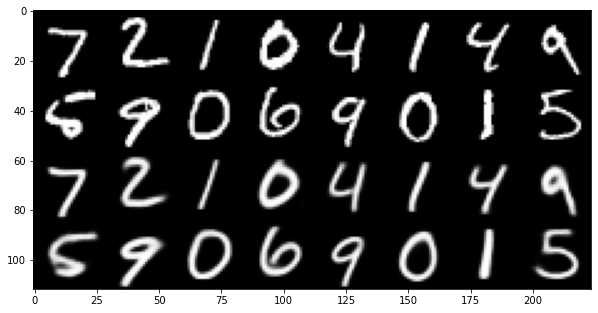

In [93]:
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model1

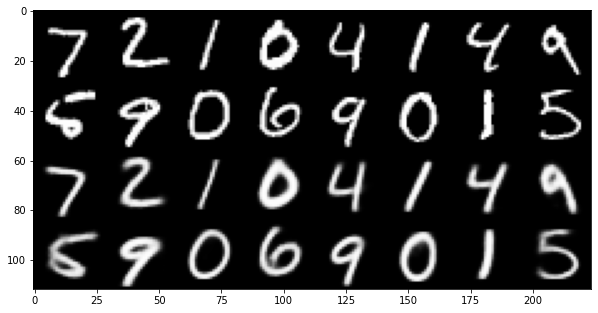

In [94]:
recon_sample = sigmoid(model2(test_sample_image.to(device), test_sample_label.to(device)).to('cpu').detach().numpy())*2-1
test_sample = np.array(test_sample_image)
ghx = []
for i in range(2):
    ghx.append(np.concatenate([test_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
for i in range(2):
    ghx.append(np.concatenate([recon_sample[8*i+j,0,:,:] for j in range(8)], axis = 1))
recon_results = np.concatenate(ghx, axis = 0)
plt.figure(figsize = (10.0, 10.0))
plt.imshow(recon_results, cmap='gray', vmin=-1, vmax=1)
plt.show() # model2

### Generation from prior distribution

In [97]:
test_z = []
test_label = []
z = gaus(6, 8)
print(z.shape)
for i in range(10):
    test_z.append(z)
    test_label.append(test_data.code[i].repeat(6,1))
    
test_z = torch.cat(test_z, dim = 0)
test_label = torch.cat(test_label, dim = 0)

Z = torch.cat([test_z, test_label], dim = 1).to(device)
Z.shape

torch.Size([6, 8])


torch.Size([60, 18])

In [98]:
gen_sample1 = sigmoid(model1.decode(Z).to('cpu').detach().numpy()) # generated samples in numpy
gen_sample2 = sigmoid(model2.decode(Z).to('cpu').detach().numpy()) # generated samples in numpy

gz = []
for i in range(10):
    tmp = [gen_sample1[6*i + j,0,:,:] for j in range(6)] + [gen_sample2[6*i + j,0,:,:] for j in range(6)]
    gz.append(np.concatenate(tmp, axis = 1))
generation_result = np.concatenate(gz, axis = 0) # concatenate matrix for plt

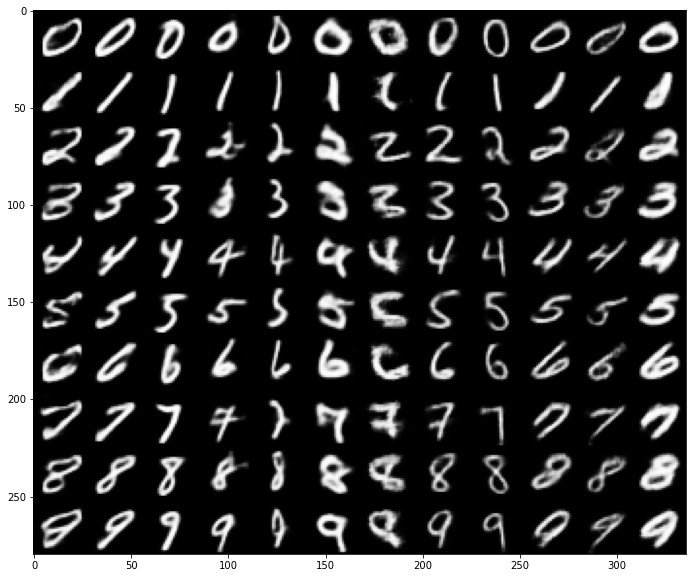

In [99]:
plt.figure(figsize = (12, 10))
plt.imshow(generation_result, cmap='gray', vmin=0, vmax=1)
plt.show()

### Sharpness and FID

In [100]:
z_sampler = lambda x : torch.cat([gaus(x, 8), multinomial(x, 10)], dim = 1).to(device)

In [103]:
sig_dec1 = lambda x: torch.sigmoid(model1.dec(x))*2-1
sharp1 = calculate_sharpness_generator(sig_dec1, z_sampler, batch_size=100, repeat=10, device=device)
np.mean(sharp1)

0.3104583559334278

In [104]:
sig_dec2 = lambda x: torch.sigmoid(model2.dec(x))*2-1
sharp2 = calculate_sharpness_generator(sig_dec2, z_sampler, batch_size=100, repeat=10, device=device)
np.mean(sharp2)

0.26520059756934644

In [105]:
fid_model = fid.InceptionV3().to(device)

In [106]:
m1, s1 = fid.calculate_activation_statistics(test_data2, fid_model, batch_size=100, dims=2048, device=device)

100%|██████████| 100/100 [00:33<00:00,  3.01it/s]


In [107]:
act1 = fid.get_activations_generator(sig_dec1, z_sampler, fid_model, batch_size=100, repeat=10, dims=2048, device=device)
m2 = np.mean(act1, axis=0)
s2 = np.cov(act1, rowvar=False)

In [108]:
fid.calculate_frechet_distance(m1, s1, m2, s2) # fid of model1

28.501627242268597

In [109]:
act2 = fid.get_activations_generator(sig_dec2, z_sampler, fid_model, batch_size=100, repeat=10, dims=2048, device=device)
m3 = np.mean(act2, axis=0)
s3 = np.cov(act2, rowvar=False)

In [110]:
fid.calculate_frechet_distance(m1, s1, m3, s3) # fid of model2

30.661722338456258